# Automated Detection of Food Hazards in Incident Reports
# Project Overview
### This Jupyter notebook implements the full code for the CST8507 - Natural Language Processing final project based on SemEval-2025 Task 9: Food Hazard Detection Challenge.

# Team Members:

### Khaled Saleh
### Yazid Rahmouni

# 1. Imports and Setup

In [4]:
# Import necessary libraries for data handling, machine learning, and visualization
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import shap
from lime.lime_text import LimeTextExplainer
import re
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Set random seed for reproducibility across numpy and torch
np.random.seed(42)
torch.manual_seed(42)


# 2. Data Loading and Preprocessing

Load and Explore Data

In [5]:
# Load the training, validation, and test datasets
train_df = pd.read_csv('incidents_train.csv')
val_df = pd.read_csv('incidents_valid.csv')
test_df = pd.read_csv('incidents_test.csv')

# Display basic information about the datasets
print("Train Dataset Shape:", train_df.shape)
print("Validation Dataset Shape:", val_df.shape)
print("Test Dataset Shape:", test_df.shape)
print("Columns:", train_df.columns.tolist())
print("\nSample Train Data:")
display(train_df.head())

# Define a function to preprocess text: lowercase, remove punctuation, and extra spaces
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text.strip())  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.lower()

# Apply preprocessing to the 'title' column in each split
train_df['processed_title'] = train_df['title'].apply(preprocess_text)
val_df['processed_title'] = val_df['title'].apply(preprocess_text)
test_df['processed_title'] = test_df['title'].apply(preprocess_text)

# Create label encoders for each target variable by fitting on all data to ensure consistency
le_prod_cat = LabelEncoder().fit(pd.concat([train_df['product-category'], val_df['product-category'], test_df['product-category']]))
le_haz_cat = LabelEncoder().fit(pd.concat([train_df['hazard-category'], val_df['hazard-category'], test_df['hazard-category']]))
le_prod = LabelEncoder().fit(pd.concat([train_df['product'], val_df['product'], test_df['product']]))
le_haz = LabelEncoder().fit(pd.concat([train_df['hazard'], val_df['hazard'], test_df['hazard']]))

# Encode the labels in each dataframe
train_df['prod_cat_label'] = le_prod_cat.transform(train_df['product-category'])
train_df['haz_cat_label'] = le_haz_cat.transform(train_df['hazard-category'])
train_df['prod_label'] = le_prod.transform(train_df['product'])
train_df['haz_label'] = le_haz.transform(train_df['hazard'])

val_df['prod_cat_label'] = le_prod_cat.transform(val_df['product-category'])
val_df['haz_cat_label'] = le_haz_cat.transform(val_df['hazard-category'])
val_df['prod_label'] = le_prod.transform(val_df['product'])
val_df['haz_label'] = le_haz.transform(val_df['hazard'])

test_df['prod_cat_label'] = le_prod_cat.transform(test_df['product-category'])
test_df['haz_cat_label'] = le_haz_cat.transform(test_df['hazard-category'])
test_df['prod_label'] = le_prod.transform(test_df['product'])
test_df['haz_label'] = le_haz.transform(test_df['hazard'])

Train Dataset Shape: (5082, 11)
Validation Dataset Shape: (565, 11)
Test Dataset Shape: (997, 11)
Columns: ['Unnamed: 0', 'year', 'month', 'day', 'country', 'title', 'text', 'hazard-category', 'product-category', 'hazard', 'product']

Sample Train Data:


,Unnamed: 0,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


# 3. Baseline Models (TF-IDF + LR/RF)
Vectorization

In [6]:
# Initialize TF-IDF vectorizer with max 5000 features and bigrams for better context capture
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform on training data, transform validation and test data
X_train = vectorizer.fit_transform(train_df['processed_title'])
X_val = vectorizer.transform(val_df['processed_title'])
X_test = vectorizer.transform(test_df['processed_title'])

# Subtask 1: Product Category and Hazard Category

In [7]:
# Train Logistic Regression for Product Category in Subtask 1
lr_prod_cat = LogisticRegression(max_iter=1000).fit(X_train, train_df['prod_cat_label'])

# Train Logistic Regression for Hazard Category in Subtask 1
lr_haz_cat = LogisticRegression(max_iter=1000).fit(X_train, train_df['haz_cat_label'])

# Make predictions on validation set
pred_prod_cat_val_lr = lr_prod_cat.predict(X_val)
pred_haz_cat_val_lr = lr_haz_cat.predict(X_val)

# Calculate Macro F1 scores
f1_prod_cat_lr = f1_score(val_df['prod_cat_label'], pred_prod_cat_val_lr, average='macro')
f1_haz_cat_lr = f1_score(val_df['haz_cat_label'], pred_haz_cat_val_lr, average='macro')

# Print results
print(f"LR Subtask 1 - Product Cat Macro F1: {f1_prod_cat_lr:.4f}")
print(f"LR Subtask 1 - Hazard Cat Macro F1: {f1_haz_cat_lr:.4f}")

# Train Random Forest for Product Category in Subtask 1
rf_prod_cat = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, train_df['prod_cat_label'])

# Train Random Forest for Hazard Category in Subtask 1
rf_haz_cat = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, train_df['haz_cat_label'])

# Make predictions on validation set
pred_prod_cat_val_rf = rf_prod_cat.predict(X_val)
pred_haz_cat_val_rf = rf_haz_cat.predict(X_val)

# Calculate Macro F1 scores
f1_prod_cat_rf = f1_score(val_df['prod_cat_label'], pred_prod_cat_val_rf, average='macro')
f1_haz_cat_rf = f1_score(val_df['haz_cat_label'], pred_haz_cat_val_rf, average='macro')

# Print results
print(f"RF Subtask 1 - Product Cat Macro F1: {f1_prod_cat_rf:.4f}")
print(f"RF Subtask 1 - Hazard Cat Macro F1: {f1_haz_cat_rf:.4f}")

LR Subtask 1 - Product Cat Macro F1: 0.5105
LR Subtask 1 - Hazard Cat Macro F1: 0.5295
RF Subtask 1 - Product Cat Macro F1: 0.5294
RF Subtask 1 - Hazard Cat Macro F1: 0.5785
RF Subtask 1 - Product Cat Macro F1: 0.5294
RF Subtask 1 - Hazard Cat Macro F1: 0.5785


# Subtask 2: Fine-Grained Product and Hazard

In [8]:
# Train Logistic Regression for Fine-Grained Product in Subtask 2
lr_prod = LogisticRegression(max_iter=1000).fit(X_train, train_df['prod_label'])

# Train Logistic Regression for Fine-Grained Hazard in Subtask 2
lr_haz = LogisticRegression(max_iter=1000).fit(X_train, train_df['haz_label'])

# Make predictions on validation set
pred_prod_val_lr = lr_prod.predict(X_val)
pred_haz_val_lr = lr_haz.predict(X_val)

# Calculate Macro F1 scores
f1_prod_lr = f1_score(val_df['prod_label'], pred_prod_val_lr, average='macro')
f1_haz_lr = f1_score(val_df['haz_label'], pred_haz_val_lr, average='macro')

# Print results
print(f"LR Subtask 2 - Product Macro F1: {f1_prod_lr:.4f}")
print(f"LR Subtask 2 - Hazard Macro F1: {f1_haz_lr:.4f}")

# Train Random Forest for Fine-Grained Product in Subtask 2
rf_prod = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, train_df['prod_label'])

# Train Random Forest for Fine-Grained Hazard in Subtask 2
rf_haz = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, train_df['haz_label'])

# Make predictions on validation set
pred_prod_val_rf = rf_prod.predict(X_val)
pred_haz_val_rf = rf_haz.predict(X_val)

# Calculate Macro F1 scores
f1_prod_rf = f1_score(val_df['prod_label'], pred_prod_val_rf, average='macro')
f1_haz_rf = f1_score(val_df['haz_label'], pred_haz_val_rf, average='macro')

# Print results
print(f"RF Subtask 2 - Product Macro F1: {f1_prod_rf:.4f}")
print(f"RF Subtask 2 - Hazard Macro F1: {f1_haz_rf:.4f}")

LR Subtask 2 - Product Macro F1: 0.1354
LR Subtask 2 - Hazard Macro F1: 0.1982
RF Subtask 2 - Product Macro F1: 0.2248
RF Subtask 2 - Hazard Macro F1: 0.3832
RF Subtask 2 - Product Macro F1: 0.2248
RF Subtask 2 - Hazard Macro F1: 0.3832


# 4. Fine-Tuned Transformer (BERT)
Dataset Class for BERT

In [9]:
# Define a custom Dataset class for BERT to handle text tokenization and labels
class FoodHazardDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts  # List of input texts
        self.labels = labels  # List of corresponding labels
        self.tokenizer = tokenizer  # BERT tokenizer
        self.max_len = max_len  # Maximum sequence length

    def __len__(self):
        return len(self.texts)  # Return the number of samples

    def __getitem__(self, idx):
        text = self.texts[idx]  # Get text at index
        label = self.labels[idx]  # Get label at index
        # Tokenize the text with padding and truncation
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        # Return dictionary with input_ids, attention_mask, and label
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load the BERT tokenizer (uncased for case-insensitivity)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Training Function for BERT

In [10]:
# Define a function to train the BERT model
def train_bert(model, dataloader, optimizer, epochs=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
    model.to(device)  # Move model to device
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0  # Initialize loss tracker
        for batch in tqdm(dataloader):  # Loop over batches with progress bar
            optimizer.zero_grad()  # Reset gradients
            input_ids = batch['input_ids'].to(device)  # Move inputs to device
            attention_mask = batch['attention_mask'].to(device)  # Move masks to device
            labels = batch['labels'].to(device)  # Move labels to device
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)  # Forward pass
            loss = outputs.loss  # Get loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            total_loss += loss.item()  # Accumulate loss
        # Print average loss for the epoch
        print(f"Epoch {epoch+1} - Average Loss: {total_loss / len(dataloader):.4f}")

# Define a function to evaluate the BERT model
def evaluate_bert(model, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
    model.to(device)  # Move model to device
    model.eval()  # Set model to evaluation mode
    predictions, true_labels = [], []  # Lists to store predictions and true labels
    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:  # Loop over batches
            input_ids = batch['input_ids'].to(device)  # Move inputs to device
            attention_mask = batch['attention_mask'].to(device)  # Move masks to device
            outputs = model(input_ids, attention_mask=attention_mask)  # Forward pass
            logits = outputs.logits  # Get logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()  # Get predicted classes
            labels = batch['labels'].cpu().numpy()  # Get true labels
            predictions.extend(preds)  # Append predictions
            true_labels.extend(labels)  # Append true labels
    # Calculate Macro F1 score
    f1 = f1_score(true_labels, predictions, average='macro')
    return f1, predictions  # Return F1 and predictions

# Subtask 1: Train BERT for Product Category

In [11]:
# Create datasets for Product Category
train_dataset_prod_cat = FoodHazardDataset(train_df['processed_title'].tolist(), train_df['prod_cat_label'].values, tokenizer)
val_dataset_prod_cat = FoodHazardDataset(val_df['processed_title'].tolist(), val_df['prod_cat_label'].values, tokenizer)

# Create DataLoaders for batching
train_loader_prod_cat = DataLoader(train_dataset_prod_cat, batch_size=32, shuffle=True)
val_loader_prod_cat = DataLoader(val_dataset_prod_cat, batch_size=32)

# Load pre-trained BERT model for classification with appropriate number of labels
model_prod_cat = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le_prod_cat.classes_))

# Set up optimizer (AdamW with learning rate 2e-5)
optimizer_prod_cat = torch.optim.AdamW(model_prod_cat.parameters(), lr=2e-5)

# Train the model
train_bert(model_prod_cat, train_loader_prod_cat, optimizer_prod_cat)

# Evaluate on validation set
f1_prod_cat_bert, pred_prod_cat_val_bert = evaluate_bert(model_prod_cat, val_loader_prod_cat)
print(f"BERT Subtask 1 - Product Cat Macro F1: {f1_prod_cat_bert:.4f}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/159 [00:00<?, ?it/s]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 159/159 [24:41<00:00,  9.32s/it]


Epoch 1 - Average Loss: 2.0908


100%|██████████| 159/159 [24:35<00:00,  9.28s/it]


Epoch 2 - Average Loss: 1.2337


100%|██████████| 159/159 [24:33<00:00,  9.27s/it]



Epoch 3 - Average Loss: 0.8671
BERT Subtask 1 - Product Cat Macro F1: 0.5436
BERT Subtask 1 - Product Cat Macro F1: 0.5436


# Subtask 1: Train BERT for Hazard Category

In [12]:
# Create datasets for Hazard Category
train_dataset_haz_cat = FoodHazardDataset(train_df['processed_title'].tolist(), train_df['haz_cat_label'].values, tokenizer)
val_dataset_haz_cat = FoodHazardDataset(val_df['processed_title'].tolist(), val_df['haz_cat_label'].values, tokenizer)

# Create DataLoaders for batching
train_loader_haz_cat = DataLoader(train_dataset_haz_cat, batch_size=32, shuffle=True)
val_loader_haz_cat = DataLoader(val_dataset_haz_cat, batch_size=32)

# Load pre-trained BERT model for classification with appropriate number of labels
model_haz_cat = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le_haz_cat.classes_))

# Set up optimizer (AdamW with learning rate 2e-5)
optimizer_haz_cat = torch.optim.AdamW(model_haz_cat.parameters(), lr=2e-5)

# Train the model
train_bert(model_haz_cat, train_loader_haz_cat, optimizer_haz_cat)

# Evaluate on validation set
f1_haz_cat_bert, pred_haz_cat_val_bert = evaluate_bert(model_haz_cat, val_loader_haz_cat)
print(f"BERT Subtask 1 - Hazard Cat Macro F1: {f1_haz_cat_bert:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 159/159 [24:54<00:00,  9.40s/it]


Epoch 1 - Average Loss: 1.0774


100%|██████████| 159/159 [24:52<00:00,  9.39s/it]


Epoch 2 - Average Loss: 0.5686


100%|██████████| 159/159 [24:45<00:00,  9.34s/it]



Epoch 3 - Average Loss: 0.4154
BERT Subtask 1 - Hazard Cat Macro F1: 0.5208
BERT Subtask 1 - Hazard Cat Macro F1: 0.5208


# Subtask 2: Train BERT for Fine-Grained Product

In [13]:
# Create datasets for Fine-Grained Product
train_dataset_prod = FoodHazardDataset(train_df['processed_title'].tolist(), train_df['prod_label'].values, tokenizer)
val_dataset_prod = FoodHazardDataset(val_df['processed_title'].tolist(), val_df['prod_label'].values, tokenizer)

# Create DataLoaders for batching
train_loader_prod = DataLoader(train_dataset_prod, batch_size=32, shuffle=True)
val_loader_prod = DataLoader(val_dataset_prod, batch_size=32)

# Load pre-trained BERT model for classification with appropriate number of labels
model_prod = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le_prod.classes_))

# Set up optimizer (AdamW with learning rate 2e-5)
optimizer_prod = torch.optim.AdamW(model_prod.parameters(), lr=2e-5)

# Train the model
train_bert(model_prod, train_loader_prod, optimizer_prod)

# Evaluate on validation set
f1_prod_bert, pred_prod_val_bert = evaluate_bert(model_prod, val_loader_prod)
print(f"BERT Subtask 2 - Product Macro F1: {f1_prod_bert:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 159/159 [24:48<00:00,  9.36s/it]


Epoch 1 - Average Loss: 6.6632


100%|██████████| 159/159 [24:52<00:00,  9.39s/it]


Epoch 2 - Average Loss: 6.0653


100%|██████████| 159/159 [25:17<00:00,  9.55s/it]



Epoch 3 - Average Loss: 5.6557
BERT Subtask 2 - Product Macro F1: 0.0162
BERT Subtask 2 - Product Macro F1: 0.0162


# Subtask 2: Train BERT for Fine-Grained Hazard

In [14]:
# Create datasets for Fine-Grained Hazard
train_dataset_haz = FoodHazardDataset(train_df['processed_title'].tolist(), train_df['haz_label'].values, tokenizer)
val_dataset_haz = FoodHazardDataset(val_df['processed_title'].tolist(), val_df['haz_label'].values, tokenizer)

# Create DataLoaders for batching
train_loader_haz = DataLoader(train_dataset_haz, batch_size=16, shuffle=True)  # Smaller batch for larger classes to save memory
val_loader_haz = DataLoader(val_dataset_haz, batch_size=16)

# Load pre-trained BERT model for classification with appropriate number of labels
model_haz = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le_haz.classes_))

# Set up optimizer (AdamW with learning rate 2e-5)
optimizer_haz = torch.optim.AdamW(model_haz.parameters(), lr=2e-5)

# Train the model
train_bert(model_haz, train_loader_haz, optimizer_haz)

# Evaluate on validation set
f1_haz_bert, pred_haz_val_bert = evaluate_bert(model_haz, val_loader_haz)
print(f"BERT Subtask 2 - Hazard Macro F1: {f1_haz_bert:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 318/318 [26:09<00:00,  4.94s/it]


Epoch 1 - Average Loss: 3.3566


100%|██████████| 318/318 [25:47<00:00,  4.87s/it]


Epoch 2 - Average Loss: 2.3160


100%|██████████| 318/318 [25:40<00:00,  4.84s/it]



Epoch 3 - Average Loss: 1.8910
BERT Subtask 2 - Hazard Macro F1: 0.1546
BERT Subtask 2 - Hazard Macro F1: 0.1546


# 5. Explainability
SHAP for Logistic Regression Baseline (Subtask 1 Product Cat Example)

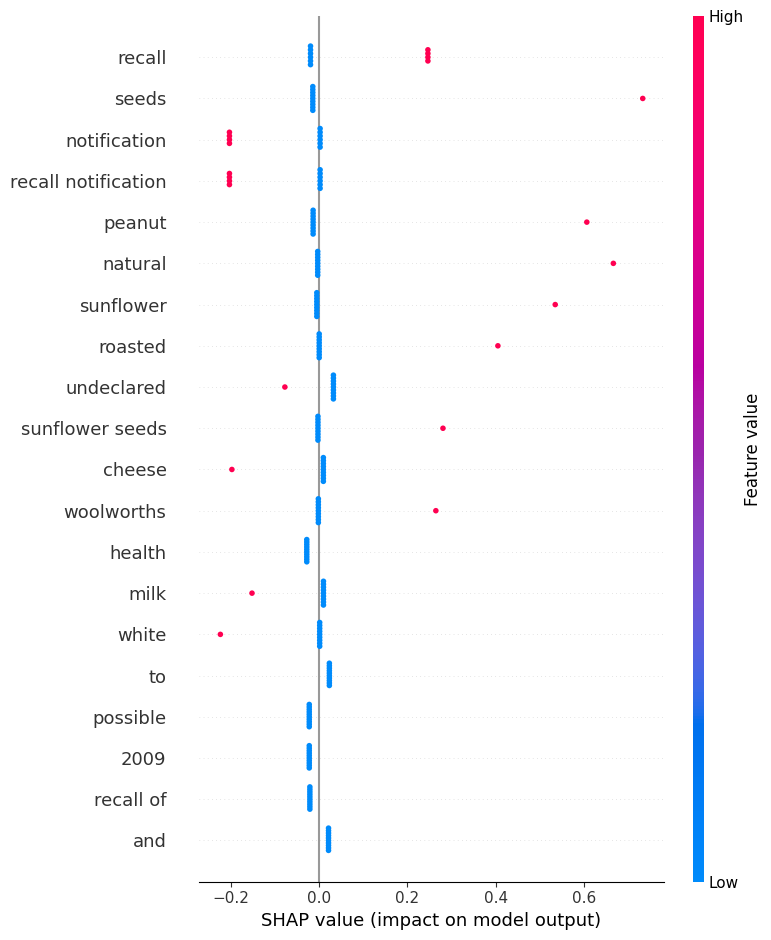

In [16]:
# Initialize SHAP explainer for Logistic Regression (using a linear masker for feature importance)
explainer_lr_prod_cat = shap.Explainer(lr_prod_cat, X_train.toarray(), feature_names=vectorizer.get_feature_names_out())

# Compute SHAP values for first 10 validation samples
shap_values_lr = explainer_lr_prod_cat(X_val[:10].toarray())

# For multiclass, select the class index you want to explain (e.g., predicted class for first sample)
class_idx = shap_values_lr[0].values.argmax(axis=1)[0] if shap_values_lr[0].values.ndim == 2 else 0

# Plot summary of SHAP values for the first sample and the selected class
shap.summary_plot(shap_values_lr.values[:, :, class_idx], X_val[:10].toarray(), feature_names=vectorizer.get_feature_names_out())

LIME for BERT (Subtask 1 Product Cat Example)

# 6. Error Analysis
Confusion Matrix Plot (BERT Subtask 1 Product Cat Example)

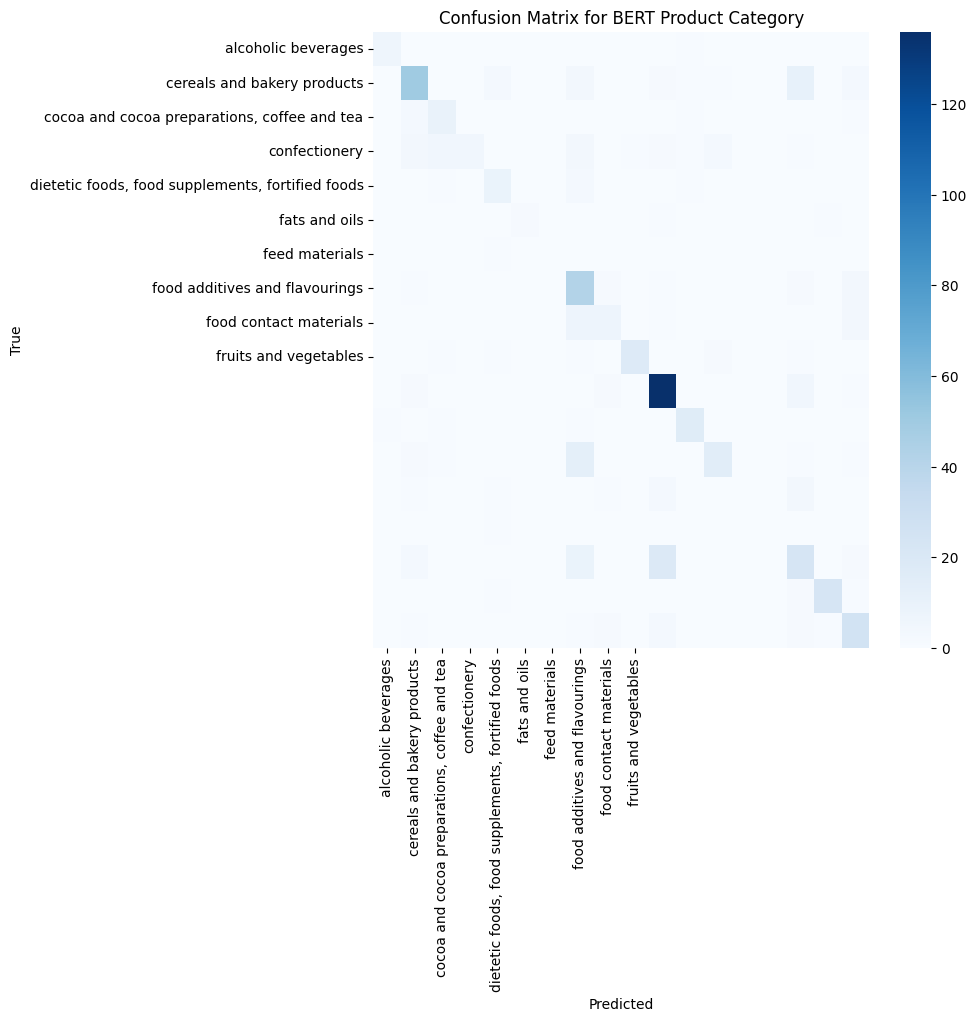

                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.86      0.86      0.86         7
                      cereals and bakery products       0.75      0.67      0.70        75
     cocoa and cocoa preparations, coffee and tea       0.53      0.67      0.59        15
                                    confectionery       1.00      0.19      0.32        26
dietetic foods, food supplements, fortified foods       0.53      0.64      0.58        14
                                    fats and oils       1.00      0.50      0.67         4
                                   feed materials       0.00      0.00      0.00         1
                   food additives and flavourings       0.00      0.00      0.00         0
                           food contact materials       0.00      0.00      0.00         0
                            fruits and vegetables       0.49      0.81      0.61        5

In [28]:
# Compute confusion matrix for BERT predictions on validation set
cm = confusion_matrix(val_df['prod_cat_label'], pred_prod_cat_val_bert)

# Plot the confusion matrix using seaborn heatmap (limited to first 10 classes for visibility if many classes)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=le_prod_cat.classes_[:10], yticklabels=le_prod_cat.classes_[:10])
plt.title('Confusion Matrix for BERT Product Category')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print detailed classification report
print(classification_report(
    val_df['prod_cat_label'],
    pred_prod_cat_val_bert,
    labels=np.arange(len(le_prod_cat.classes_)),
    target_names=le_prod_cat.classes_
))

# Find indices of misclassified samples and print first 5
mis_idx = np.where(pred_prod_cat_val_bert != val_df['prod_cat_label'])[0][:5]
print("\nSample Misclassified Instances:")
for idx in mis_idx:
    print(f"Text: {val_df['title'].iloc[idx]}")
    print(f"True: {le_prod_cat.inverse_transform([val_df['prod_cat_label'].iloc[idx]])[0]}")
    print(f"Pred: {le_prod_cat.inverse_transform([pred_prod_cat_val_bert[idx]])[0]}\n")

# Final Test Set Evaluation (BERT Subtask 1 Product Cat Example)

In [26]:
# Create test dataset and loader for Product Category
test_dataset_prod_cat = FoodHazardDataset(test_df['processed_title'].tolist(), test_df['prod_cat_label'].values, tokenizer)
test_loader_prod_cat = DataLoader(test_dataset_prod_cat, batch_size=32)

# Evaluate on test set
f1_test_prod_cat, _ = evaluate_bert(model_prod_cat, test_loader_prod_cat)
print(f"Test Set - BERT Subtask 1 Product Cat Macro F1: {f1_test_prod_cat:.4f}")

Test Set - BERT Subtask 1 Product Cat Macro F1: 0.5283


# Repeat similar evaluation for other models and subtasks as needed by duplicating the structure

In [27]:
# --- Baseline Models Evaluation on Test Set ---

# Make predictions with LR for Subtask 1 on test set
pred_prod_cat_test_lr = lr_prod_cat.predict(X_test)
pred_haz_cat_test_lr = lr_haz_cat.predict(X_test)

# Calculate Macro F1 scores for LR Subtask 1
f1_prod_cat_test_lr = f1_score(test_df['prod_cat_label'], pred_prod_cat_test_lr, average='macro')
f1_haz_cat_test_lr = f1_score(test_df['haz_cat_label'], pred_haz_cat_test_lr, average='macro')

# Print results
print(f"Test Set - LR Subtask 1 - Product Cat Macro F1: {f1_prod_cat_test_lr:.4f}")
print(f"Test Set - LR Subtask 1 - Hazard Cat Macro F1: {f1_haz_cat_test_lr:.4f}")

# Make predictions with RF for Subtask 1 on test set
pred_prod_cat_test_rf = rf_prod_cat.predict(X_test)
pred_haz_cat_test_rf = rf_haz_cat.predict(X_test)

# Calculate Macro F1 scores for RF Subtask 1
f1_prod_cat_test_rf = f1_score(test_df['prod_cat_label'], pred_prod_cat_test_rf, average='macro')
f1_haz_cat_test_rf = f1_score(test_df['haz_cat_label'], pred_haz_cat_test_rf, average='macro')

# Print results
print(f"Test Set - RF Subtask 1 - Product Cat Macro F1: {f1_prod_cat_test_rf:.4f}")
print(f"Test Set - RF Subtask 1 - Hazard Cat Macro F1: {f1_haz_cat_test_rf:.4f}")

# Make predictions with LR for Subtask 2 on test set
pred_prod_test_lr = lr_prod.predict(X_test)
pred_haz_test_lr = lr_haz.predict(X_test)

# Calculate Macro F1 scores for LR Subtask 2
f1_prod_test_lr = f1_score(test_df['prod_label'], pred_prod_test_lr, average='macro')
f1_haz_test_lr = f1_score(test_df['haz_label'], pred_haz_test_lr, average='macro')

# Print results
print(f"Test Set - LR Subtask 2 - Product Macro F1: {f1_prod_test_lr:.4f}")
print(f"Test Set - LR Subtask 2 - Hazard Macro F1: {f1_haz_test_lr:.4f}")

# Make predictions with RF for Subtask 2 on test set
pred_prod_test_rf = rf_prod.predict(X_test)
pred_haz_test_rf = rf_haz.predict(X_test)

# Calculate Macro F1 scores for RF Subtask 2
f1_prod_test_rf = f1_score(test_df['prod_label'], pred_prod_test_rf, average='macro')
f1_haz_test_rf = f1_score(test_df['haz_label'], pred_haz_test_rf, average='macro')

# Print results
print(f"Test Set - RF Subtask 2 - Product Macro F1: {f1_prod_test_rf:.4f}")
print(f"Test Set - RF Subtask 2 - Hazard Macro F1: {f1_haz_test_rf:.4f}")

# --- BERT Models Evaluation on Test Set ---

# Create test dataset and loader for Subtask 1 Product Category
test_dataset_prod_cat = FoodHazardDataset(test_df['processed_title'].tolist(), test_df['prod_cat_label'].values, tokenizer)
test_loader_prod_cat = DataLoader(test_dataset_prod_cat, batch_size=32)

# Evaluate on test set
f1_test_prod_cat_bert, _ = evaluate_bert(model_prod_cat, test_loader_prod_cat)
print(f"Test Set - BERT Subtask 1 - Product Cat Macro F1: {f1_test_prod_cat_bert:.4f}")

# Create test dataset and loader for Subtask 1 Hazard Category
test_dataset_haz_cat = FoodHazardDataset(test_df['processed_title'].tolist(), test_df['haz_cat_label'].values, tokenizer)
test_loader_haz_cat = DataLoader(test_dataset_haz_cat, batch_size=32)

# Evaluate on test set
f1_test_haz_cat_bert, _ = evaluate_bert(model_haz_cat, test_loader_haz_cat)
print(f"Test Set - BERT Subtask 1 - Hazard Cat Macro F1: {f1_test_haz_cat_bert:.4f}")

# Create test dataset and loader for Subtask 2 Fine-Grained Product
test_dataset_prod = FoodHazardDataset(test_df['processed_title'].tolist(), test_df['prod_label'].values, tokenizer)
test_loader_prod = DataLoader(test_dataset_prod, batch_size=32)

# Evaluate on test set
f1_test_prod_bert, _ = evaluate_bert(model_prod, test_loader_prod)
print(f"Test Set - BERT Subtask 2 - Product Macro F1: {f1_test_prod_bert:.4f}")

# Create test dataset and loader for Subtask 2 Fine-Grained Hazard
test_dataset_haz = FoodHazardDataset(test_df['processed_title'].tolist(), test_df['haz_label'].values, tokenizer)
test_loader_haz = DataLoader(test_dataset_haz, batch_size=16)  # Smaller batch if needed for memory

# Evaluate on test set
f1_test_haz_bert, _ = evaluate_bert(model_haz, test_loader_haz)
print(f"Test Set - BERT Subtask 2 - Hazard Macro F1: {f1_test_haz_bert:.4f}")

Test Set - LR Subtask 1 - Product Cat Macro F1: 0.4463
Test Set - LR Subtask 1 - Hazard Cat Macro F1: 0.5417
Test Set - RF Subtask 1 - Product Cat Macro F1: 0.4249
Test Set - RF Subtask 1 - Hazard Cat Macro F1: 0.5827
Test Set - LR Subtask 2 - Product Macro F1: 0.0787
Test Set - LR Subtask 2 - Hazard Macro F1: 0.1764
Test Set - RF Subtask 2 - Product Macro F1: 0.2293
Test Set - RF Subtask 2 - Hazard Macro F1: 0.3359
Test Set - RF Subtask 2 - Product Macro F1: 0.2293
Test Set - RF Subtask 2 - Hazard Macro F1: 0.3359
Test Set - BERT Subtask 1 - Product Cat Macro F1: 0.5283
Test Set - BERT Subtask 1 - Product Cat Macro F1: 0.5283
Test Set - BERT Subtask 1 - Hazard Cat Macro F1: 0.5135
Test Set - BERT Subtask 1 - Hazard Cat Macro F1: 0.5135
Test Set - BERT Subtask 2 - Product Macro F1: 0.0096
Test Set - BERT Subtask 2 - Product Macro F1: 0.0096
Test Set - BERT Subtask 2 - Hazard Macro F1: 0.1491
Test Set - BERT Subtask 2 - Hazard Macro F1: 0.1491
